In [1]:
# from data_process import *

# train_loader, test_loader = load_mnist()


In [2]:
from model import *
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

device = 'cuda'
model = SimpleUnet().to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))

model_path = '/home/longvv/generative_model/models/diffusion_mnist_fixed.pth'
model.load_state_dict(torch.load(model_path, weights_only=True))

Num params:  62248577


<All keys matched successfully>

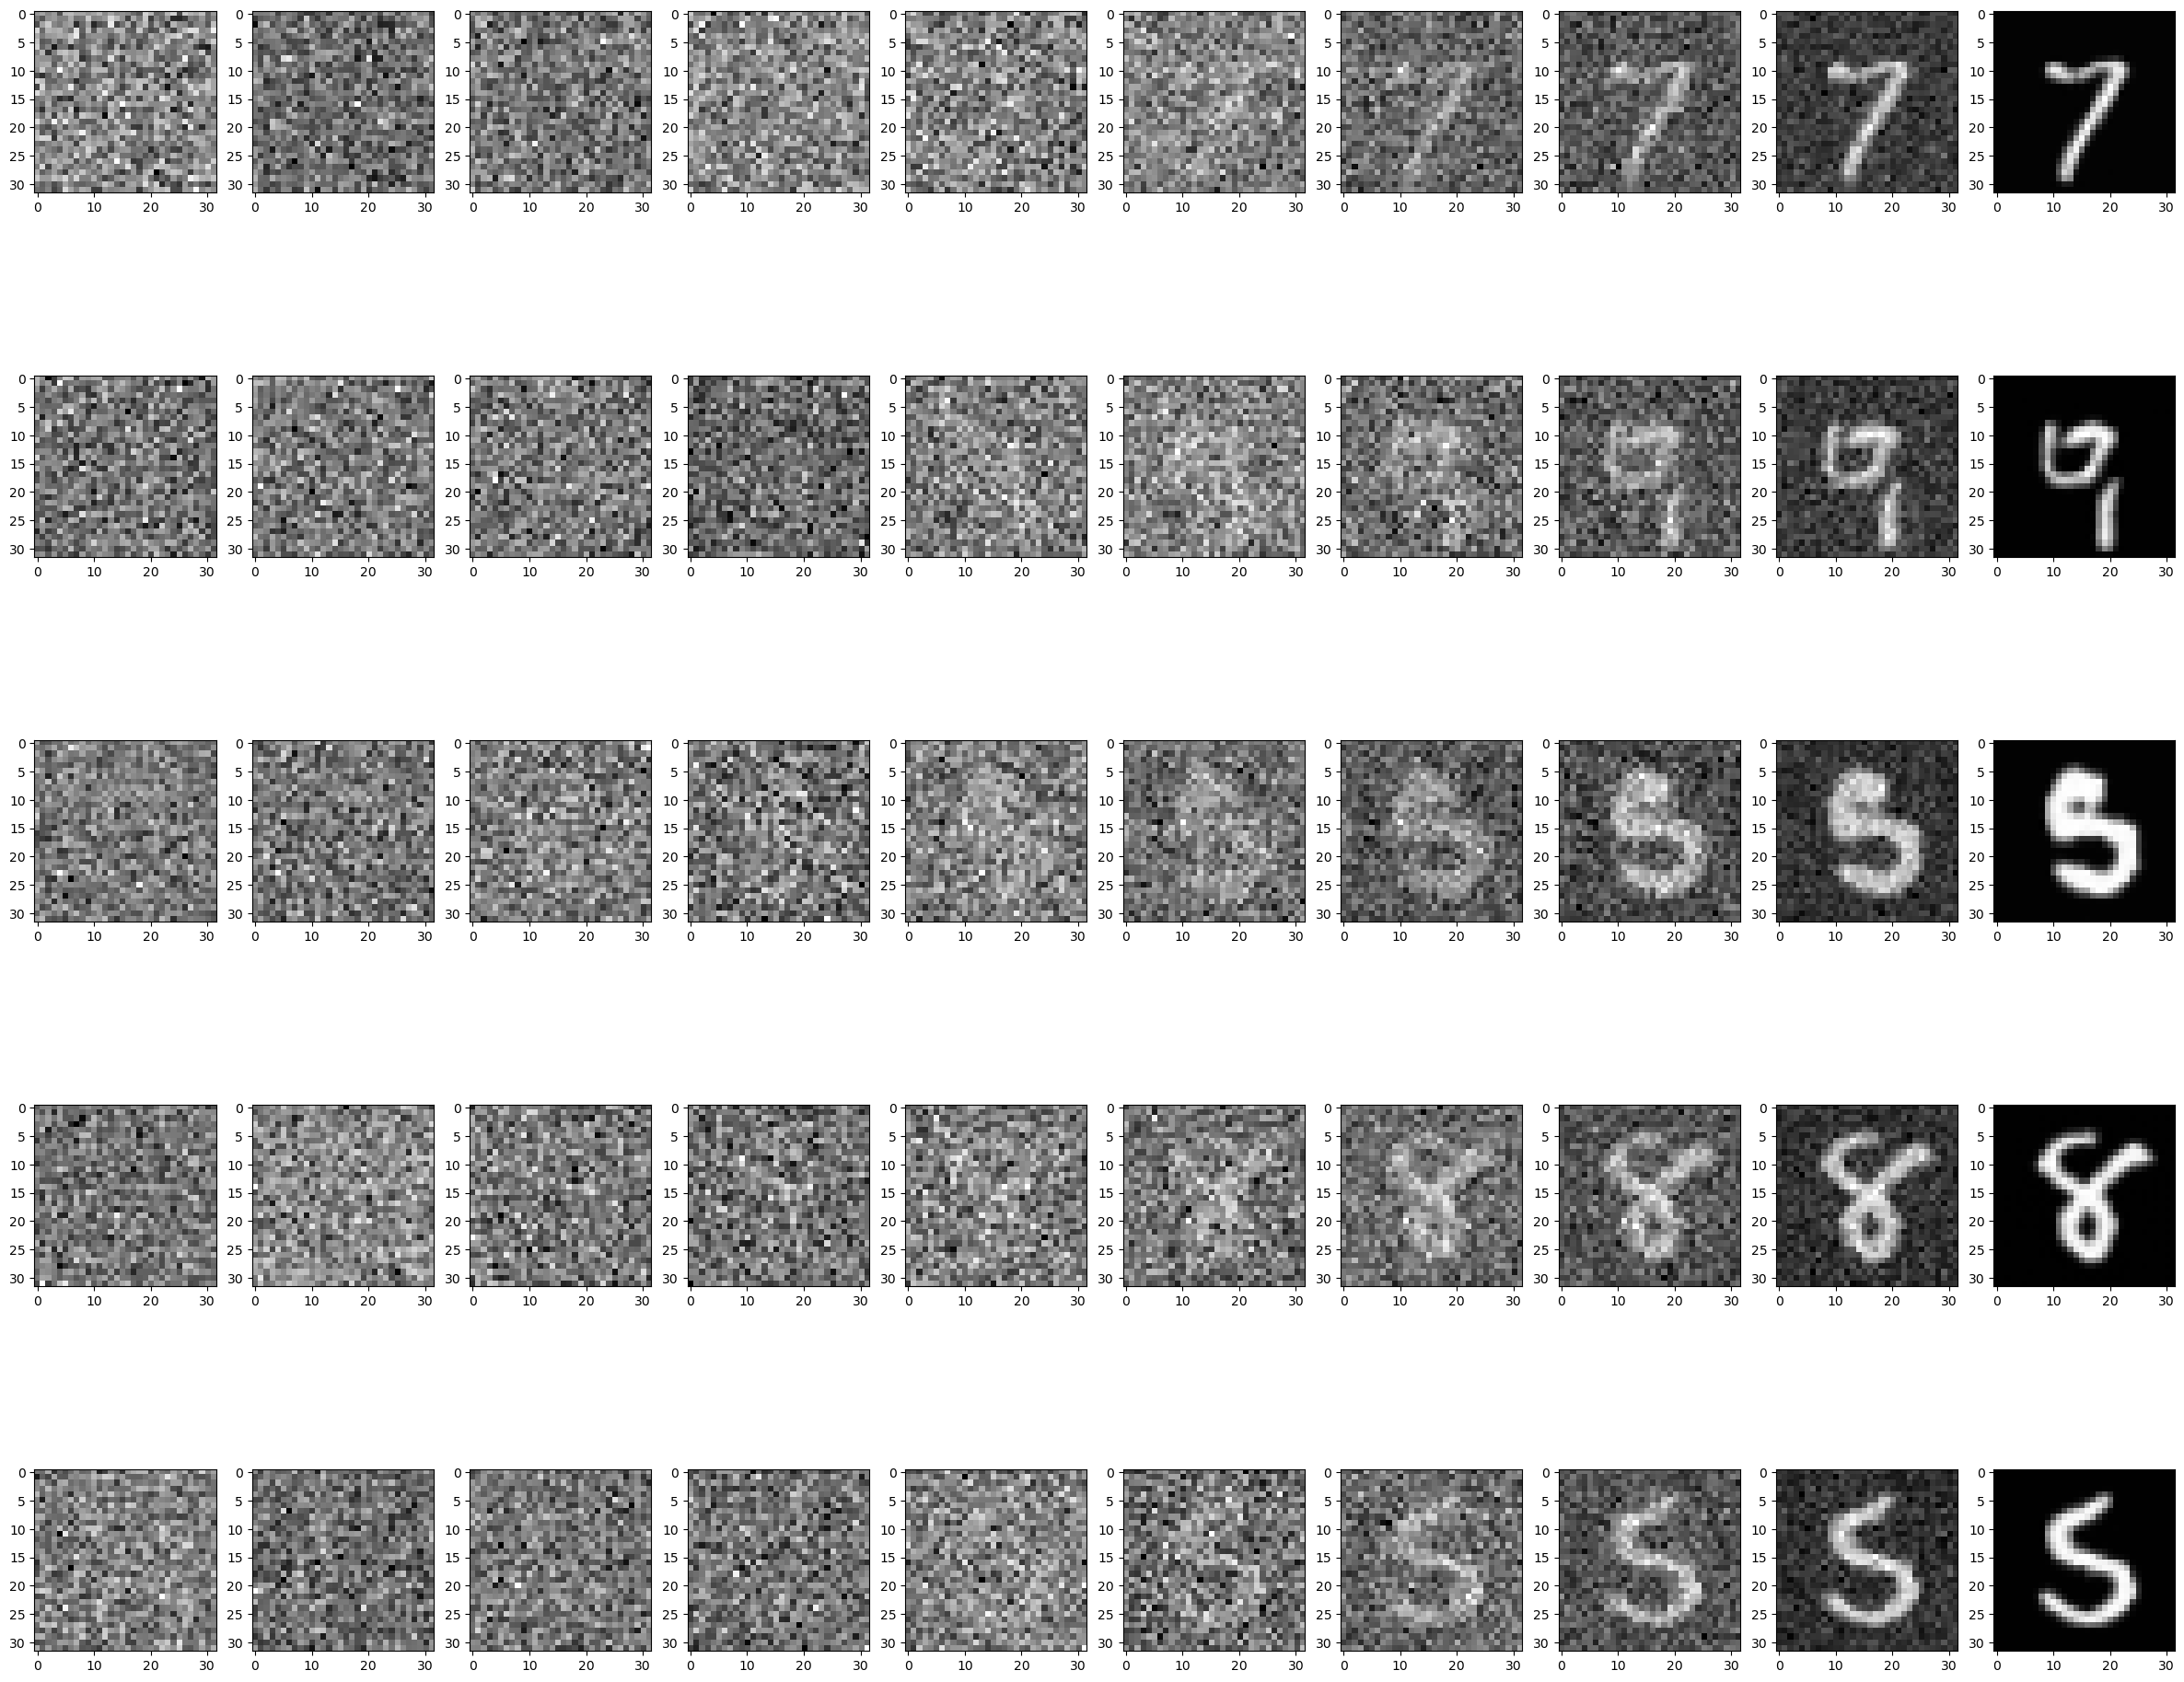

In [3]:
T = 500
start = 0.0001
end = 0.05
device = 'cuda'
IMG_SIZE = 32
BATCH_SIZE = 512

betas = torch.linspace(start, end, T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis = 0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 


def show_images(img_name, dataset, num_samples=50, cols=10, save = True):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(30,30)) 
    for i, img in enumerate(dataset):
        img = img.detach().to('cpu')
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        
        #for mnist image only, if u need colored stuff, stick with 'convert_to_image' function in source code 
        plt.imshow(img.squeeze(dim=0), cmap='gray')
    
    if (save == True):
        name = 'output' + str(img_name) + '.png'
        plt.savefig('/home/longvv/generative_model/diffusion-real/result/' + name)
    plt.show()

# i will sample a combo of 5 images, 5 diffuse image each
@torch.no_grad()
def sample_plot_image(img_name):
    # Sample noise
    img_size = IMG_SIZE
    img_set = []
    num_images = 50
    num_images_each = 10
    stepsize = int(T/num_images_each)

    model.eval()
    for id in range (0, num_images//num_images_each):
        img = torch.randn((1, 1, img_size, img_size), device=device)
        for i in range(0,T)[::-1]:
            t = torch.full((1,), i, device=device, dtype=torch.long)
            img = sample_timestep(img, t)
            # Edit: This is to maintain the natural range of the distribution
            # img = torch.clamp(img, 0.0, 1.0)
            if i % stepsize == 0:
                img_set.append(img.squeeze(dim = 0))
            
    show_images(img_name, img_set, num_samples=num_images, cols=10, save = True)

sample_plot_image('test_sample')